In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728168419.772173   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728168419.825577   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728168419.826979   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
import keras_cv
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

I0000 00:00:1728168420.540276   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728168420.541476   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728168420.542459   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728168420.696346   56983 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

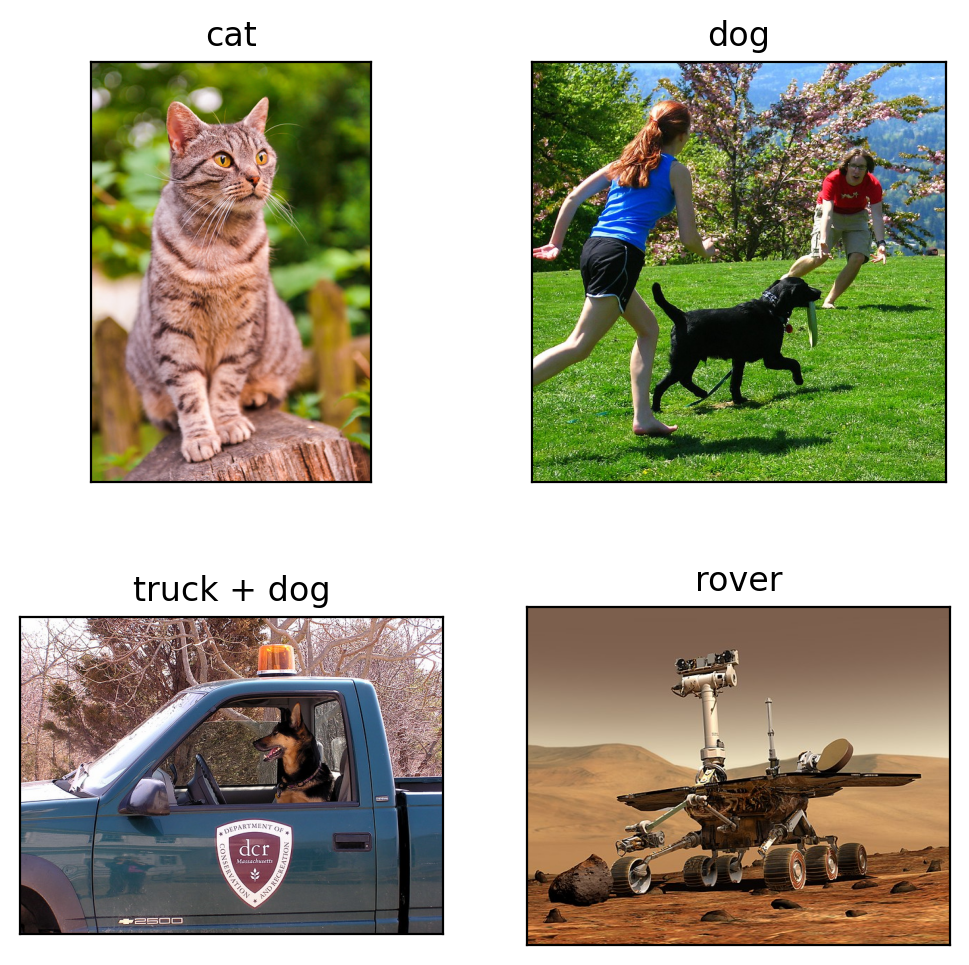

In [3]:
from collegium.m02_cnn.utils.plot import *

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()
plot_images_grid(images_raw)

In [4]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
model_inputs = {
    k: inference_resizing(i)
    for k, i in images_raw.items()
}

In [5]:
# Running a forward pass through the network with the input image.
model_outputs = {
    k: model.predict(i[None, :])
    for k, i in model_inputs.items()
}

/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


I0000 00:00:1728168428.825512   57125 service.cc:146] XLA service 0x7078b0001e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728168428.825536   57125 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
E0000 00:00:1728168433.144188   57125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728168433.345512   57125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


I0000 00:00:1728168437.311184   57125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [6]:
# The result is a dictionary of tensors, so let's look at the shapes.
{name: r.shape for name, r in model_outputs['cat'].items()}

{'boxes': (1, 100, 4),
 'confidence': (1, 100),
 'classes': (1, 100),
 'num_detections': (1,)}

In [7]:
# We need to load a mapping between integer class IDs and English labels.
# There is a helper function in utils folder to do just that.

from collegium.m02_cnn.utils.pascalvoc import load_class_map
class_map = load_class_map()
class_map

label
0      Aeroplane
1        Bicycle
2           Bird
3           Boat
4         Bottle
5            Bus
6            Car
7            Cat
8          Chair
9            Cow
10  Dining Table
11           Dog
12         Horse
13     Motorbike
14        Person
15  Potted Plant
16         Sheep
17          Sofa
18         Train
19     Tvmonitor
20         Total

In [13]:
# Now we can use the data frame from above to convert
# the model output (integer IDs) to the corresponding English labels.
import pandas as pd

def model_output_to_scores_df(model_output: dict) -> pd.DataFrame:
    class_ids = np.clip(model_output['classes'][0].astype(int), 1, None)
    class_labels = class_map.loc[class_ids].reset_index(drop=True)
    class_scores = pd.Series(model_output['confidence'][0]).rename('score')

    class_predictions = pd.concat([class_labels, class_scores], axis=1)
    class_predictions = class_predictions.sort_values('score', ascending=False)
    class_predictions = class_predictions.loc[class_predictions['score'] > 0.5]
    
    return class_predictions

def plot_image_with_boxes(input_image: np.ndarray, model_output: dict):
    class_ids = np.clip(model_output['classes'][0].astype(int), 1, None)
    class_labels = class_map.loc[class_ids].reset_index(drop=True)
    
    image_with_boxes = draw_boxes(
        np.array(input_image), 
        model_output["boxes"][0],
        class_labels.label.values,
        model_output["confidence"][0],
        min_score=0.50
    )
    plt.figure(figsize=[4, 4])
    plot_image(image_with_boxes)

label     score
0   Cat  0.982692

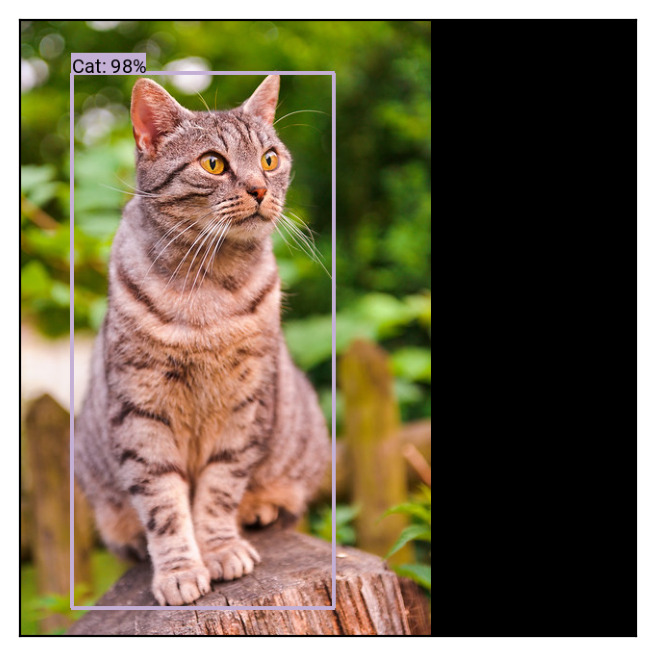

In [14]:
plot_image_with_boxes(model_inputs['cat'], model_outputs['cat'])
model_output_to_scores_df(model_outputs['cat']).head(5)

label     score
0  Person  0.975997
1  Person  0.942449
2     Dog  0.907465

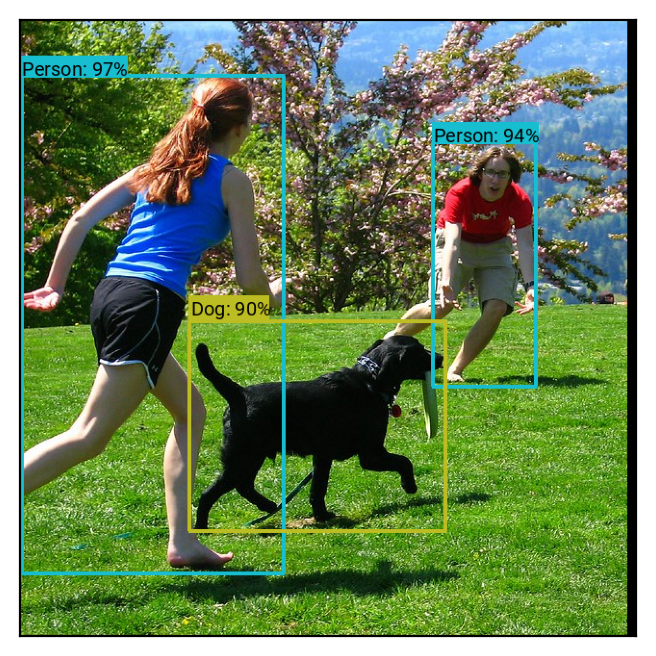

In [15]:
plot_image_with_boxes(model_inputs['dog'], model_outputs['dog'])
model_output_to_scores_df(model_outputs['dog']).head(5)

label     score
0   Dog  0.948363
1   Car  0.812112

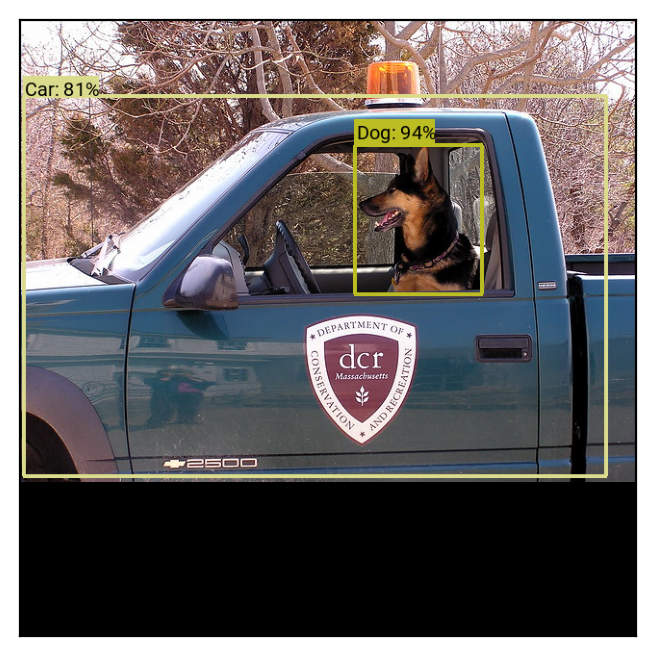

In [16]:
plot_image_with_boxes(model_inputs['truck + dog'], model_outputs['truck + dog'])
model_output_to_scores_df(model_outputs['truck + dog']).head(5)

Empty DataFrame
Columns: [label, score]
Index: []

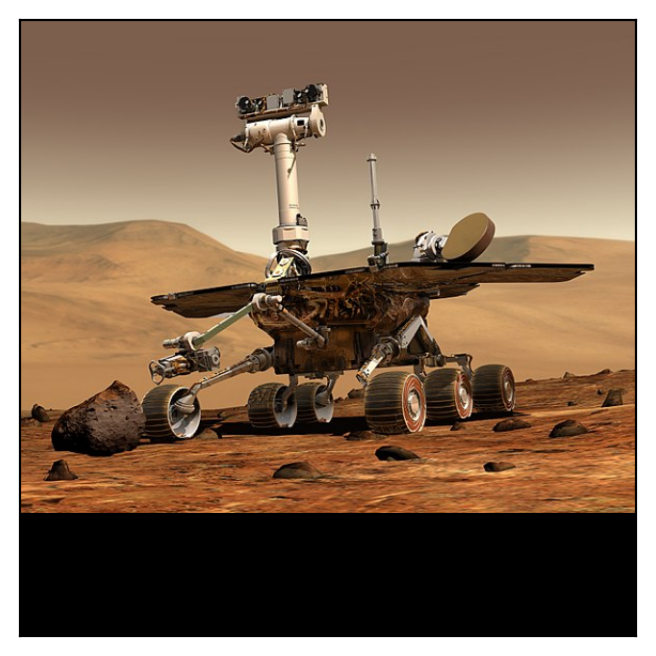

In [17]:
plot_image_with_boxes(model_inputs['rover'], model_outputs['rover'])
model_output_to_scores_df(model_outputs['rover']).head(5)